**Issues to resolve**

- Two optDMDs... what should they be called to avoid ambiguities?
- svd_rank issues in BOP-DMD (hangs for some cases, fails linear svd solve in others, successful in others)
- Difference in language: DMD class has .predict, BOP-DMD has .forecast. Both behave differently (predict does one "time step" into the future, forecast uses an arbitrarily spaced time vector)
- DMD cannot store actual time steps, partially contributing to the above issue. Similarly, BOP-DMD does not have `original_timesteps` or `dmd_timesteps` variables.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import pydmd
from pydmd.bopdmd import BOPDMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMD
from pydmd.plotter import plot_eigs
from pydmd.plotter import plot_modes_2D
import scipy

# This library is useful for generating accurate colored noise
import colorednoise as cn

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def relative_error(xprime, x):
    return np.linalg.norm(xprime - x) / np.linalg.norm(x)

In [3]:
def simple_example(spatial_modes, eigenvalue_array, ts):
    x = np.zeros((spatial_modes[0].size, ts.size), np.complex128)
    for sp, e in zip(spatial_modes, eigenvalue_array):
        x += sp.dot(np.exp(e * ts))
    return x

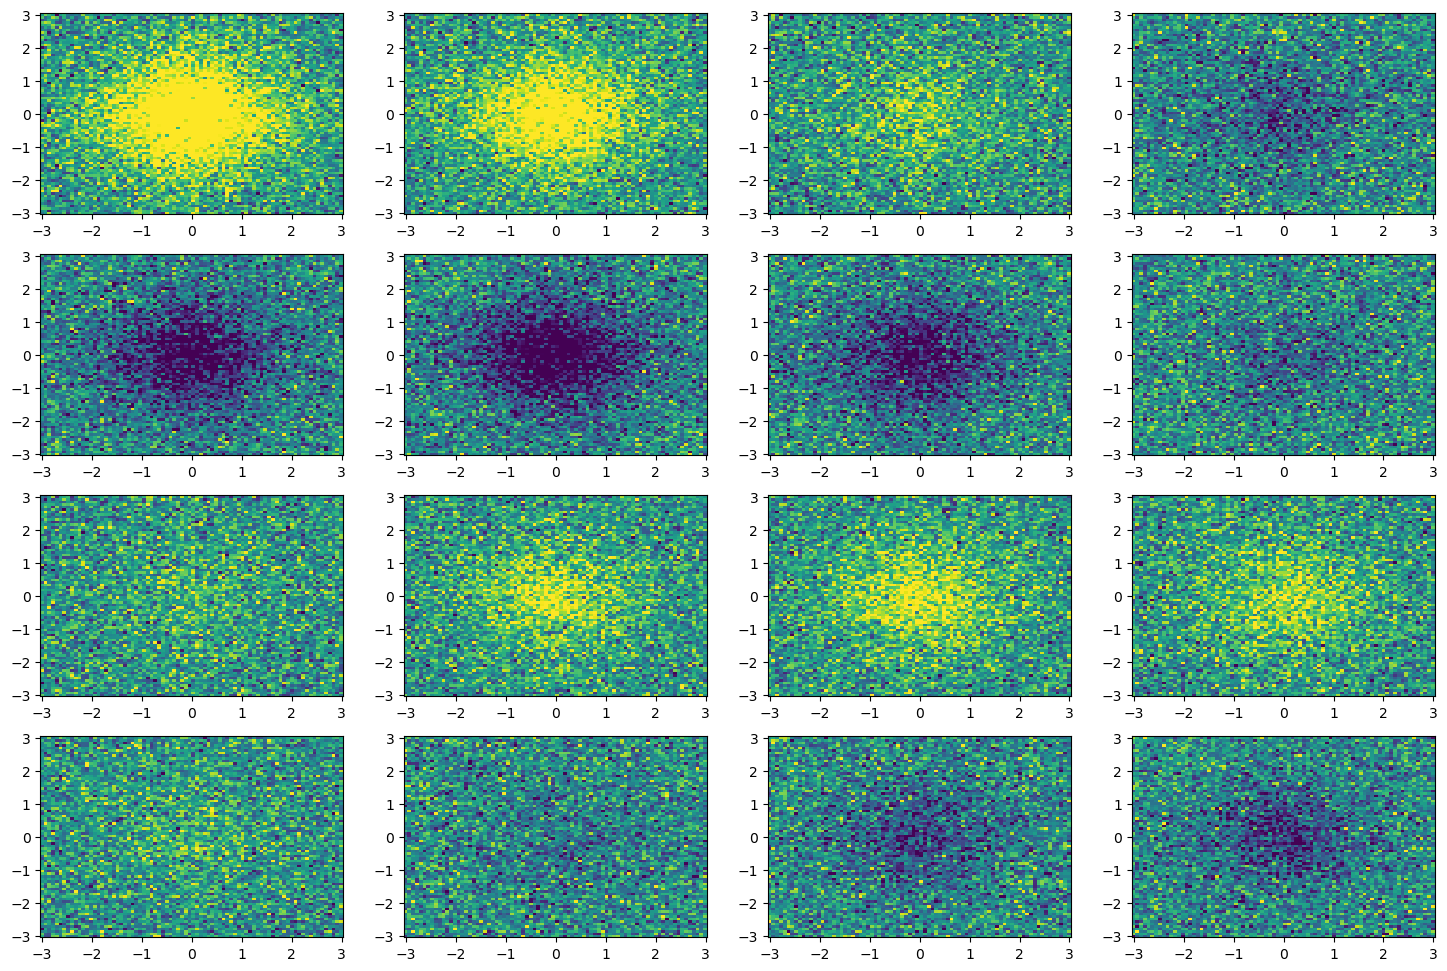

In [4]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

time = np.linspace(0, 6, 16)

data = [2/np.cosh(x1grid)/np.cosh(x2grid)*(1.2j**-t) for t in time]
noise = [np.random.normal(0.0, 0.4, size=x1grid.shape) for t in time]

snapshots = [d+n for d,n in zip(data, noise)]

fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)

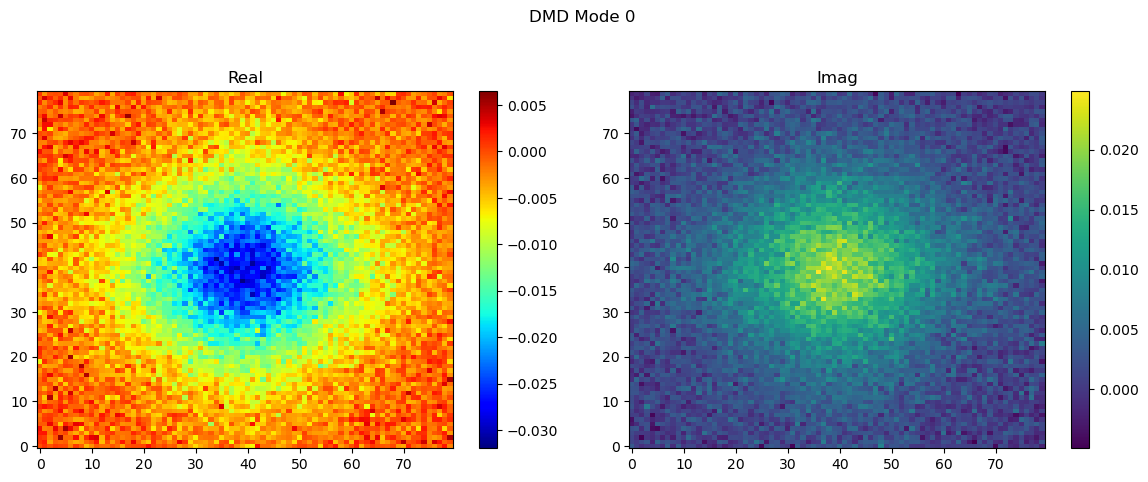

In [5]:
dmd = DMD(svd_rank=1, tlsq_rank=2, exact=True, opt=True)
dmd.fit(snapshots)
plot_modes_2D(dmd, figsize=(12,5))

In [6]:
dmd.growth_rate

array([0.75123756])

In [7]:
dmd.frequency

array([-0.10001149])

In [8]:
dmd.dmd_time['dt'] = 0.25
dmd.frequency

array([-0.10001149])

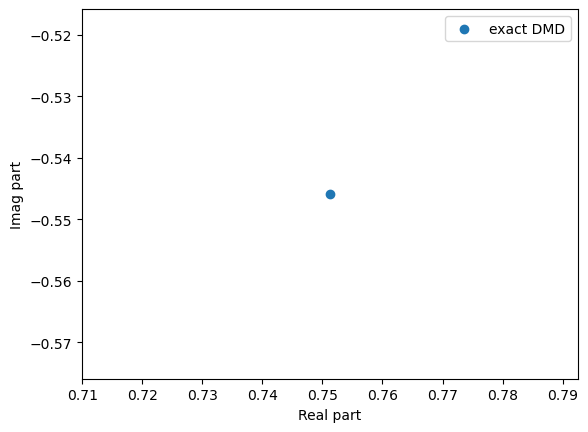

In [9]:
fig, ax = plt.subplots(1, 1)
# ax.scatter(true_eigenvalues.real, true_eigenvalues.imag, 100, label='True Eigenvalues', color='k')
# ax.scatter(np.real(optdmd.eigs), np.imag(optdmd.eigs), label='optDMD')
# ax.scatter(np.real(bopdmd.eigs), np.imag(bopdmd.eigs), label='BOP-DMD')
ax.scatter(np.real(dmd.eigs), np.imag(dmd.eigs), label='exact DMD')
ax.set_xlabel('Real part')
ax.set_ylabel('Imag part')
ax.legend()

In [ ]:
dmd_states = [state.reshape(x1grid.shape) for state in dmd.reconstructed_data.T]
bopdmd_states = [state.reshape(x1grid.shape) for state in bopdmd.reconstructed_data.T]

compute_integral = scipy.integrate.trapz

original_int = [compute_integral(compute_integral(snapshots_2d[:, :, nt])).real for nt , _ in enumerate(time)]
# dmd_int = np.array([compute_integral(compute_integral(state)).real for state in dmd_states])

# original_int = np.array([compute_integral(compute_integral(snapshot)).real for snapshot in snapshots_1d])
# dmd_int = np.array([compute_integral(compute_integral(state)).real for state in dmd_states])
# bopdmd_int = np.array([compute_integral(compute_integral(state)).real for state in bopdmd_states])

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax = axes[0]
ax.plot(time, original_int, 'bo', label='original snapshots')
# ax.plot(time, dmd_int, 'r.', label='dmd states')
# ax.plot(time, bopdmd_int, 'k.', label='bopdmd states')
ax.set_ylabel('Integral')
ax.set_xlabel('Time')
ax.grid()
ax.legend()

# ax = axes[1]
# ax.plot(time, dmd_int - original_int, 'r.', ls='-', label='dmd')
# ax.plot(time, bopdmd_int - original_int, 'k.', ls='-', label='bopdmd')
# ax.set_ylabel('Error in Integral')
# ax.set_xlabel('Time')
# ax.axhline(0, color='0.6')
# ax.grid()
# ax.legend()